In [15]:
#View Dataset Details
import os
import glob

base_dir = os.path.join(r'C:\Users\DEEPIKA JALAMANCHILI\Downloads\archive\train')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(10334, 10334)

In [16]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,C:\Users\DEEPIKA JALAMANCHILI\Downloads\archiv...,healthy
1,C:\Users\DEEPIKA JALAMANCHILI\Downloads\archiv...,malaria
2,C:\Users\DEEPIKA JALAMANCHILI\Downloads\archiv...,healthy
3,C:\Users\DEEPIKA JALAMANCHILI\Downloads\archiv...,malaria
4,C:\Users\DEEPIKA JALAMANCHILI\Downloads\archiv...,healthy


In [17]:
#Create Train, Validation and Test Datasets
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(13020,) (1447,) (6201,)
Train: Counter({'malaria': 6517, 'healthy': 6503}) 
Val: Counter({'malaria': 740, 'healthy': 707}) 
Test: Counter({'healthy': 3124, 'malaria': 3077})


In [18]:
#Get Image Dimension Summary Stats
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-2_0: working on img num: 0
ThreadPoolExecutor-2_10: working on img num: 5000
ThreadPoolExecutor-2_0: working on img num: 10000
ThreadPoolExecutor-2_10: working on img num: 13019
Min Dimensions: [40 55  3]
Avg Dimensions: [133.13686636 132.60368664   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [382 265   3]


In [19]:
#Load and Resize Images
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-3_0: working on img num: 0
ThreadPoolExecutor-3_1: working on img num: 5000
ThreadPoolExecutor-3_2: working on img num: 10000
ThreadPoolExecutor-3_5: working on img num: 13019

Loading Validation Images:
ThreadPoolExecutor-3_10: working on img num: 0
ThreadPoolExecutor-3_8: working on img num: 1446

Loading Test Images:
ThreadPoolExecutor-3_6: working on img num: 0
ThreadPoolExecutor-3_1: working on img num: 5000
ThreadPoolExecutor-3_8: working on img num: 6200


((13020, 125, 125, 3), (1447, 125, 125, 3), (6201, 125, 125, 3))

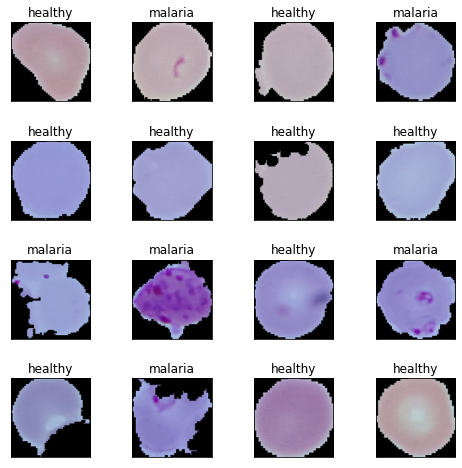

In [20]:
#View Sample Cell Images
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [21]:
#Setup config settings, Scale Images & Label encode classes
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'malaria' 'malaria' 'healthy' 'healthy'] [1 1 1 1 0 0]


In [22]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

tf.random.set_seed(42)
tf.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.6.0'

In [23]:
#Model 1: CNN
#Build Model Architecture
import tensorflow as tf
INPUT_SHAPE = (125, 125, 3)
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 128)       0   

In [24]:
#Train Model
import datetime

logdir = os.path.join('/home/dipanzan_sarkar/projects/tensorboard_logs', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/25
204/204 [==============================] - 306s 1s/step - loss: 0.5605 - accuracy: 0.6909 - val_loss: 0.2228 - val_accuracy: 0.9309
Epoch 2/25
204/204 [==============================] - 305s 1s/step - loss: 0.1914 - accuracy: 0.9370 - val_loss: 0.1702 - val_accuracy: 0.9454
Epoch 3/25
204/204 [==============================] - 312s 2s/step - loss: 0.1463 - accuracy: 0.9548 - val_loss: 0.1674 - val_accuracy: 0.9454
Epoch 4/25
204/204 [==============================] - 299s 1s/step - loss: 0.1244 - accuracy: 0.9608 - val_loss: 0.1401 - val_accuracy: 0.9558
Epoch 5/25
204/204 [==============================] - 295s 1s/step - loss: 0.1145 - accuracy: 0.9618 - val_loss: 0.1334 - val_accuracy: 0.9551
Epoch 6/25
204/204 [==============================] - 254s 1s/step - loss: 0.0958 - accuracy: 0.9681 - val_loss: 0.1431 - val_accuracy: 0.9558
Epoch 7/25
204/204 [==============================] - 237s 1s/step - loss: 0.0757 - accuracy: 0.9737 - val_loss: 0.1331 - val_accuracy: 0.9530

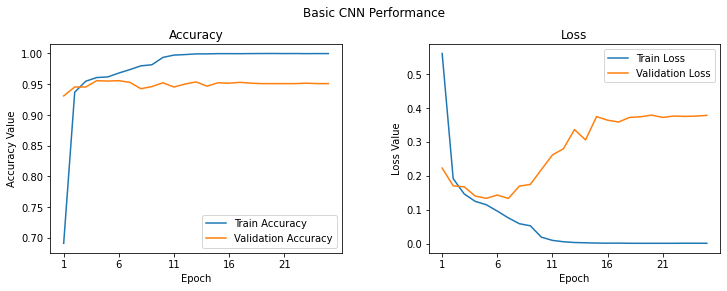

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [26]:
#Save Model
model.save('basic_cnn.h5')

In [27]:
#Model 2: Frozen Pre-trained CNN
#Build Model Architecture
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0   

In [28]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


In [ ]:
#Train Model
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/25
204/204 [==============================] - 1263s 6s/step - loss: 0.4202 - accuracy: 0.8005 - val_loss: 0.4086 - val_accuracy: 0.8148
Epoch 2/25
204/204 [==============================] - 1390s 7s/step - loss: 0.3054 - accuracy: 0.8699 - val_loss: 0.2554 - val_accuracy: 0.8936
Epoch 3/25
204/204 [==============================] - 1216s 6s/step - loss: 0.2724 - accuracy: 0.8866 - val_loss: 0.3084 - val_accuracy: 0.8618
Epoch 4/25
204/204 [==============================] - 1093s 5s/step - loss: 0.2542 - accuracy: 0.8970 - val_loss: 0.2436 - val_accuracy: 0.8998
Epoch 5/25
204/204 [==============================] - 1088s 5s/step - loss: 0.2338 - accuracy: 0.9085 - val_loss: 0.2136 - val_accuracy: 0.9143
Epoch 6/25
204/204 [==============================] - 1271s 6s/step - loss: 0.2216 - accuracy: 0.9115 - val_loss: 0.1982 - val_accuracy: 0.9226
Epoch 7/25
204/204 [==============================] - 1742s 9s/step - loss: 0.2115 - accuracy: 0.9162 - val_loss: 0.2657 - val_accuracy:

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")